<a href="https://colab.research.google.com/github/vardanagarwal/SIH/blob/master/Segmentation_unet_cluster_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8MB 16kB/s 
     |████████████████████████████████| 450kB 52.1MB/s 
     |████████████████████████████████| 3.9MB 54.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ee4a60da18075776feea7c46e8281251068ba574bb54b2a2bd79b9d07f4f3771
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Fo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
zf = zipfile.ZipFile('/content/drive/My Drive/sky_segmentation/0_training.zip', "r")
zf.extractall()
zf1 = zipfile.ZipFile('/content/drive/My Drive/sky_segmentation/0_testing.zip', "r")
zf1.extractall()
zf2 = zipfile.ZipFile('/content/drive/My Drive/sky_segmentation/mask.zip', "r")
zf2.extractall()

In [0]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import pandas as pd

In [0]:
train_imgs = glob("0_training/*.jpg")
print(len(train_imgs))
train_remove = pd.read_csv('/content/drive/My Drive/sky_segmentation/corrupt_training_0.csv')
train_names = train_remove.name
for train_name in train_names:
  pth = os.path.join('0_training', train_name)
  os.remove(pth)
train_imgs = glob("0_training/*.jpg")
print(len(train_imgs))

test_imgs = glob("0_testing/*.jpg")
print(len(test_imgs))
test_remove = pd.read_csv('/content/drive/My Drive/sky_segmentation/corrupt_testing_0.csv')
test_names = test_remove.name
for test_name in test_names:
  pth = os.path.join('0_testing', test_name)
  os.remove(pth)
test_imgs = glob("0_testing/*.jpg")
print(len(test_imgs))


38241
38058
9665
9625


In [0]:
SIZE = 224
N_CLASSES = 2

def parse_image_train(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "0_training", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    camid = tf.strings.split(tf.strings.split(mask_path, os.path.sep)[-1], '-')[-0]
    mask_path = tf.strings.regex_replace(mask_path, r'[0-9_-]+', camid)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.image.rgb_to_grayscale(mask)
    #mask = tf.where(mask == 255, np.dtype('uint8').type(1), mask)
    return {'image': image, 'segmentation_mask': mask}

def parse_image_validate(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "0_testing", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    camid = tf.strings.split(tf.strings.split(mask_path, os.path.sep)[-1], '-')[-0]
    mask_path = tf.strings.regex_replace(mask_path, r'[0-9_-]+', camid)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.image.rgb_to_grayscale(mask)
    #mask = tf.where(mask == 255, np.dtype('uint8').type(1), mask)
    return {'image': image, 'segmentation_mask': mask}

train_imgs = tf.data.Dataset.list_files("0_training/*.jpg")
val_imgs = tf.data.Dataset.list_files("0_testing/*.jpg")
train_set = train_imgs.map(parse_image_train)
test_set = val_imgs.map(parse_image_validate)
dataset = {"train": train_set, "test": test_set}

def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (SIZE, SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE, SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (SIZE, SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE, SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

train_imgs = glob("0_training/*.jpg")
TRAIN_LENGTH = len(train_imgs)

test_imgs = glob("0_testing/*.jpg")
TEST_LENGTH = len(test_imgs)

BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

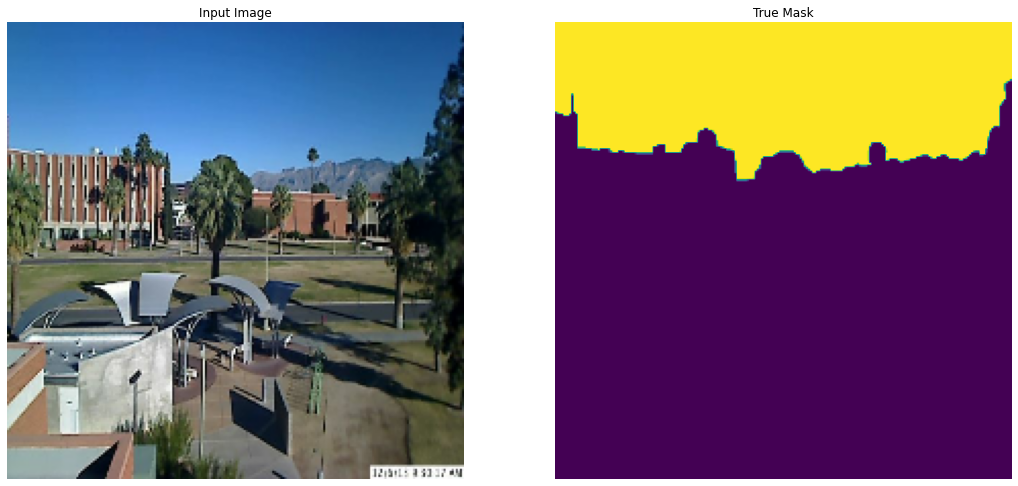

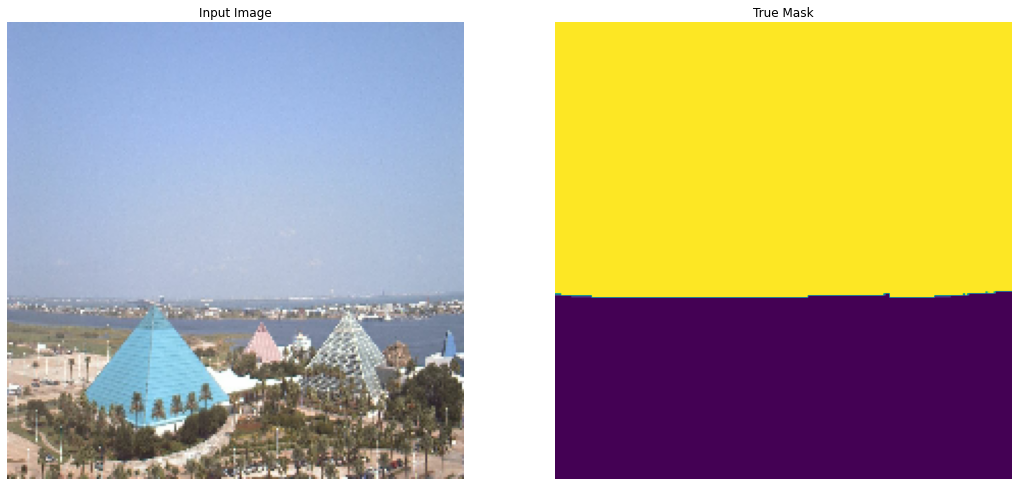

In [0]:
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in test.take(2):
    sample_image, sample_mask = image, mask
    display_sample([sample_image, sample_mask])

In [0]:
OUTPUT_CHANNELS = 2
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# tf.keras.utils.plot_model(model, show_shapes=True)

9412608/9406464 [==============================] - 0s 0us/step


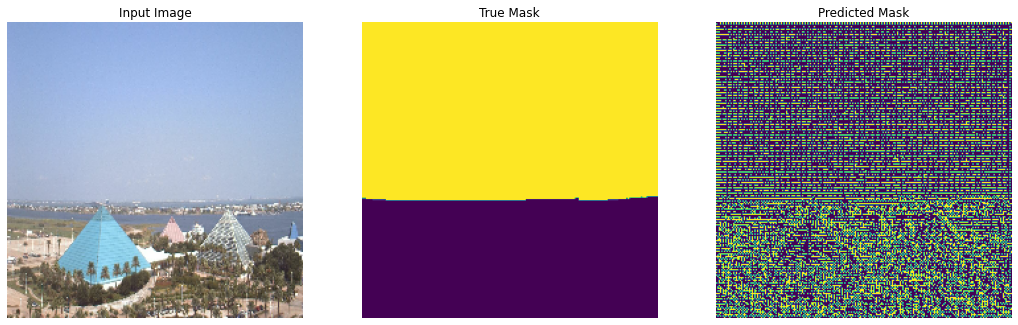

In [0]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model=model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_sample([sample_image, sample_mask,
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 20
VAL_SUBSPLITS = 2
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Train for 594 steps, validate for 75 steps
Epoch 1/20
450/594 [=====================>........] - ETA: 1:39 - loss: 0.1719 - accuracy: 0.9433

In [0]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [0]:
show_predictions(test_dataset, 3)